In [2]:
from ortools.sat.python import cp_model
import random
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
import random
import numpy as np
import pickle
import signal
import csv 
import time
import config

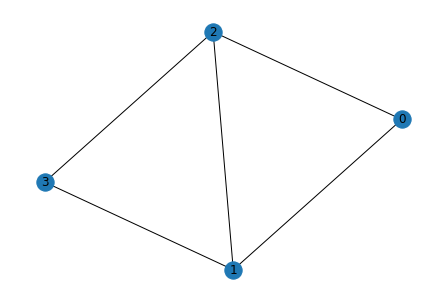

In [3]:
G = nx.Graph()
G.add_nodes_from([0,1,2,3])
G.add_edges_from([(0,1),(0,2),(1,3),(2,3),(1,2)])
nx.draw(G, with_labels=True)


# Gerador de grafos aleatorios(n,p)

In [4]:
def generateGraph(n,p):
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(i,n):
            if(i!=j):
                if(random.uniform(0, 1) <= p ):
                    G.add_edge(i,j)
    return G
                

# Gerador de grafos da classe Stacked Book

In [5]:
def generateStackedBookGraph(n,m):
    G1 = nx.Graph()
    H1 = nx.Graph()
    H1 = nx.star_graph(m)
    G1 = nx.path_graph(n)
    P1 = nx.cartesian_product(H1, G1)
    # nx.draw(P, with_labels=True)
    lista = sorted(P1)
    mapping ={}
    for no, novo in zip(lista,range(len(lista))):
        mapping[no] = novo
    A = nx.relabel_nodes(P1, mapping)
    return A

# G=  generateStackedBookGraph(2,3)
# nx.draw(G, with_labels=True)

# Model Number Grundy

In [6]:
def model_grundy(grafo, upperbound):

    solver = pywraplp.Solver.CreateSolver('SCIP')
    solver.set_time_limit(900000)
    x = {}
    for v in grafo.nodes:
        for c in range(upperbound):
            name = "x[%s,%s]" % (v, c)
            x[v, c] = solver.IntVar(0, 1, name)

    z = {}
    for c in range(upperbound):
        name = "z[%d]" % c
        z[c] = solver.IntVar(0, 1, name)

    for v in grafo.nodes:
        solver.Add(solver.Sum([x[v, c] for c in range(upperbound)]) == 1)

    for c in range(upperbound):
        solver.Add(z[c] <= solver.Sum([x[v, c] for v in grafo.nodes]))

    for (u, v) in grafo.edges:
        for c in range(upperbound):
            solver.Add(x[u, c] + x[v, c] <= z[c])

    for v in grafo.nodes:
        for c in range(upperbound):
            solver.Add(x[v, c] >= 1 - solver.Sum(x[v, d]
                       for d in range(0, c)) - solver.Sum(x[u, c] for u in grafo.adj[v]))

    solver.Maximize(solver.Sum(z[c] for c in range(upperbound)))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # print('Solução:')
        print('Valor da função Objetivo =', solver.Objective().Value())
        # for v in grafo.nodes:
        #     for c in range(upperbound):
        #         print("%.2f" %(x[v, c].solution_value()), end=' ')
        #     print()
        return solver.Objective().Value()
    else:
        print('Sem solução ótima.')
        return solver.Objective().Value()


# Implementacao Coloração Gulosa

In [7]:
def corMinima(G, index, coloracao):
    vizinhos = set([])
    for y in G.adj[index]:
        if(coloracao[y] != -1):
            vizinhos.add(coloracao[y])
    c = set(range(1, len(G.nodes)+1))
#     print(c.difference(vizinhos))
    return min(c.difference(vizinhos))

def coloracaoGulosa(G, ordervertex):
    c = []
    for x in G.nodes:
        c.append(-1)
    for index in ordervertex:
        c[index] = corMinima(G, index, c)
    print("vertex color", c)
    return max(c)


In [8]:
nodes = list(range(0,len(G.nodes)))
random.shuffle(nodes)
print("nodes ",nodes)
print("maxcolor",coloracaoGulosa(G,nodes))

nodes  [2, 3, 1, 0]
vertex color [2, 3, 1, 2]
maxcolor 3


# Upper Bound - Stair factor

In [9]:
def calcGrau(G):
    grau = {}
    for i in G.nodes:
        grau[i] = len(G.adj[i])
    return grau

def calcMaxGrau(G):
    maxgrau = 0
    for i in G.nodes:
        maxgrau = max(maxgrau,len(G.adj[i]))
    return maxgrau

def ordemCrescenteGrau(G):
    grauMax = 0
    bin = {}
    pos = {}
    vert = {}

    graus = calcGrau(G)

    for v in G.nodes:
        grauMax = max(grauMax, graus[v])

    for d in range(grauMax+1):
        bin[d] = 0

    for v in G.nodes:
        bin[graus[v]] += 1

    start = 1
    for d in range(grauMax+1):
        num = bin[d]
        bin[d] = start
        start += num

    for v in G.nodes:
        pos[v] = bin[graus[v]]
        vert[pos[v]] = v
        bin[graus[v]] += 1

    for d in range(grauMax, 0, -1):
        bin[d] = bin[d-1]
    bin[0] = 1

    # print('bin ',bin,'\n')
    # print('\nvert ',vert,'\n')
    # print('pos',pos,'\n')
    # print('graus',graus,'\n')

    return bin, vert, pos, graus

def vertex_decomposition(G):
    G = G.copy()
    ordem = []
    graus_ordem = {}

    bin, vert, pos, graus = ordemCrescenteGrau(G)

    for i in range(len(G.nodes), 0, -1):
        v = vert[i]
        for u in G.adj[v]:
            # if graus[u] > graus[v]:
            du = graus[u]
            pu = pos[u]
            pw = bin[du]
            w = vert[pw]
            if u == w:
                pos[u] = pw
                vert[pu] = w
                pos[w] = pu
                vert[pw] = u
            bin[du] += 1
            graus[u] -= 1
        # G.remove_node(v)

        graus_ordem[v] = graus[v]
        ordem.append(v)

    # print('Ordem de decomposicao', ordem, '\n')
    # print('Graus dos vertices da ordem', graus_ordem, '\n')

    return ordem, graus_ordem


def stairfactor(G):
    # graus = calcGrau(G)
    ordem, graus_ordem = vertex_decomposition(G)

    stairfactor = np.inf
    for ind, vertex in zip(range(1,len(ordem)+1), ordem):
        stairfactor = min(stairfactor, graus_ordem[vertex]+ind)
    return stairfactor



# Algorithm BronKerbosch - findCliques

In [10]:
def findCliques(G,P, R=None, X=None,cliques=[]):
    P = set(P)
    R = set() if R is None else R
    X = set() if X is None else X
    if not P and not X:
        cliques.append(R)
        # yield R
    try:
        u = random.choice(list(P.union(X)))
        S = P.difference(G.adj[u])
    # if union of P and X is empty
    except IndexError:
        S = P
    for v in S:
        findCliques(G=G,P=P.intersection(G.adj[v]), R=R.union([v]), X=X.intersection(G.adj[v]),cliques=cliques)
        P.remove(v)
        X.add(v)

def findCliques3(G):
    P = set(list(G.nodes()))
    R = set() 
    X = set() 
    cliques = []
    ordem , graus = vertex_decomposition(G)
    # print(ordem)
    for v in reversed(ordem):
        findCliques(G=G,P=P.intersection(G.adj[v]), R={v}, X=X.intersection(G.adj[v]),cliques=cliques)
        P.remove(v)
        X.add(v)
    return cliques

# ck=[]
# findCliques(G=Z,P=dict(Z.nodes()),cliques=ck)
# print(ck)
# print("\n")
# print()
# print(findCliques3(Z))

# Lawler - dynamic programming algorithm

In [11]:
def powerset(s):
    power_set=[[]]
    for elem in s:
        for sub_set in power_set:
            power_set=power_set+[list(sub_set)+[elem]]
    return power_set

    
def lawler(G):
    n = len(G.nodes())
    x = dict()
    lastname=''
    subsets = list(powerset(G.nodes()))
    for a in subsets:
        name = ' '.join([str(elem) for elem in a])
        x[name] = 0
        lastname=name
    
    for a in subsets:
        name = ' '.join([str(elem) for elem in a])
        x[name] = 0
        
        COMP = nx.complement(G.subgraph(a))
        # for i in list(nx.find_cliques(COMP)):
        for i in findCliques3(G=COMP):
            # print("i ",i)
            if(list(i) != []):
                # print("teste - ",list(i))
                s_i = list(set(a) - set(i))
                if(s_i==[] or s_i==None):
                    #  print("S_I Vazio ,",s_i)
                    x[name] = max(x[name],x[""] + 1)
                else:
                    # print("Aqui ,",sorted(s_i))
                    name_s_i = ' '.join([str(elem) for elem in sorted(s_i)])
                    # print(name_s_i)
                    x[name] = max(x[name],x[name_s_i] + 1)
                    print(x[name])
                    config.k = max(x[name],config.k)
                    # print(po)
    # print(x[lastname])
    return x[lastname]

        

# Branch-and-Bound - Number Grundy

In [12]:

class Bound:
    def __init__(self):
        self.ub = 0
        self.lb = 0
        self.maxCor=0
        self.coloracao = []
    
    def __str__(self) -> str:
        return 'UB={self.ub}, LB={self.lb} maxCor={self.maxCor}'.format(self=self)

def coloracaoInicial(G):
    c = []
    for x in G.nodes:
        c.append(-1)
    return c

def TodosVerticeColoridos(c):
    if(-1 in c):
        return False
    return True

def coresDisponiveis(G,v,color,ub):
    vizinhos = set([])
    # print(color," --- ",G.nodes)
    for y in G.adj[v]:
        # print("y ",y)
        if(color[y]!=-1):
            vizinhos.add(color[y])
    c = list(range(1,ub+1))
    if(vizinhos==set([])):
        return c
    for x in vizinhos:
        if x in c:
            c.remove(x)
    
    # print("ub ",ub," c",c," vizinhos ",vizinhos," coloracao ",color)
    return c

def BAB(Grafo,limiteSuperior):
    bound = Bound()
    bound.lb = 0
    bound.ub = limiteSuperior
    # b.ub = corMaxima(G)+1
    bound.coloracao = coloracaoInicial(Grafo)
    # print(bound.coloracao)
    bound.maxCor =0
    # V = list(G.nodes)
    
    V,graus = vertex_decomposition(Grafo)
    # V = list(reversed(V))
    # print("Ordem -> ",V)
    # print("Graus -> ",calcGrau(Grafo))
    BABNumberGrundy(Grafo, V, bound, graus,bound.coloracao.copy())
    return bound.maxCor

def isGrundyColoring(Grafo,coloracao):
    for no in Grafo.nodes():
        cor = coloracao[no]
        coresUsadas = set({})
        for x in Grafo.adj[no]:
            if coloracao[x] not in coresUsadas and coloracao[x]<cor:
                coresUsadas.add(coloracao[x])
        # print("No ",no," Cor ",cor," Cores usadas",coresUsadas, " ADJ ",Grafo.adj[no])
        if(cor!=len(coresUsadas)+1):
            # print("Saida - ",cor," ",coresUsadas)
            return False
    return True


def BABNumberGrundy(Grafo, V, b, graus,coloracao):
    if(TodosVerticeColoridos(coloracao) == True):
        if isGrundyColoring(Grafo,coloracao):
            
            if max(coloracao) > b.lb:
                b.lb = max(b.lb,max(coloracao))
                b.maxCor = max(b.lb,b.maxCor)
                b.coloracao = coloracao
                config.k = max(b.maxCor,config.k)
    else:
        # index = random.randint(0, len(V)-1)
        index = 0
        valores = coresDisponiveis(Grafo, V[index], coloracao.copy(), min(len(Grafo.adj[V[index]])+1,b.ub))
        for cor in list(reversed(valores)):
            nova_coloracao = coloracao.copy()
            nova_coloracao[V[index]] = cor
            corMaxima = max(nova_coloracao)
               
            if(corMaxima >= b.lb):
                new_V = V.copy()
                new_V.remove(new_V[index])
                
                BABNumberGrundy(Grafo, new_V, b,graus,nova_coloracao.copy())
            # else:
            #     print(corMaxima," ",b.lb)
                # BABNumberGrundy(G, V, b,graus,coloracao)


# Gerando Instancias

In [13]:
# for i in range(10):
#     for numv in {10,15,20,25,30}:
#         for prob in {0.1,0.3,0.5,0.7,0.9}:
#             dg = generateGraph(numv,prob)
#             # nx.draw(dg, with_labels=True)
#             nx.write_gml(dg, "instancias/random/random_graph_{}_{}_{}.gml".format(i,numv,prob))
#             # pickle.dump(dg, open("instancias/random/random_graph_{}_{}_{}.txt".format(i,numv,prob), 'wb'))

In [14]:
# for n in range(2,10):
#     for m in range(3,10):
#         dg = generateStackedBookGraph(n,m)
#         # nx.draw(dg, with_labels=True)
#         nx.write_gml(dg, "instancias/classe/classe_graph_{}_{}".format(n,m))
        # pickle.dump(dg, open("instancias/classe/classe_graph_{}_{}.txt".format(n,m), 'wb'))

# Visualizando Instancias

In [15]:
# # dg = pickle.load(open('/tmp/graph.txt'))
# for i in range(10):
#     for numv in {10,15,20,25,30}:
#         for prob in {0.1,0.3,0.5,0.7,0.9}:
#             # dg = generateGraph(numv,prob)
#             dg = nx.read_gml("instancias/random/random_graph_{}_{}_{}.gml".format(i,numv,prob))
#             # nx.draw(dg, with_labels=True)

# Teste Computacionais Grafos Aleatorios

In [16]:
class Timeout(Exception):
    pass


def handler(sig, frame):
    raise Timeout


In [17]:
# header = ['prob','vertices', 'arestas','delta','stairfactor','densidade','grundy','tempo']
# with open('dados_random/PLI_N.csv', 'w', encoding='UTF8') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)

In [22]:
lv = [10,15,20,25]
lprob = [0.1,0.3, 0.5, 0.7, 0.9]
# lprob = [0.3]

for numv in lv:
    for prob in lprob:
        for i in range(5):
            # dg = generateStackedBookGraph(n,m)
            # nx.draw(dg, with_labels=True)
            dg = nx.read_gml(
                "instancias/random/random_graph_{}_{}_{}.gml".format(i, numv, prob), destringizer=int)
            stf = stairfactor(dg)
            delta = calcMaxGrau(dg)+1
            vertices = len(dg.nodes())
            arestas = len(dg.edges())
            densidade = (2*arestas) / (vertices*(vertices-1))
            densidade = float("{:.4f}".format(densidade))

            signal.signal(signal.SIGALRM, handler)
            signal.alarm(900)
            try:
                start_time = time.time()

                g = model_grundy(dg, vertices)

                # g = model_grundy(dg, stf)
                # g = model_grundy(dg, delta)
                # g = BAB(dg,stf)
                # g = BAB(dg, delta)
                # g = BAB(dg,6)
                # g = lawler(dg)

                final_time = (time.time() - start_time)
                final_time = float("{:.4f}".format(final_time))
                config.k = 0
                data = [prob, vertices, arestas, delta,
                        stf, densidade, float(g), final_time]
                with open('dados_random/PLI_N.csv', 'a', encoding='UTF8') as f:
                    writer = csv.writer(f)
                    writer.writerow(data)
            except Timeout:
                data = [prob, vertices, arestas, delta,
                        stf, densidade, float(config.k), 900.0]
                with open('dados_random/PLI_N.csv', 'a', encoding='UTF8') as f:
                    writer = csv.writer(f)
                    writer.writerow(data)


Valor da função Objetivo = 2.0
Valor da função Objetivo = 2.0
Valor da função Objetivo = 3.0
Valor da função Objetivo = 2.0
Valor da função Objetivo = 3.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 5.0
Valor da função Objetivo = 4.999999999999999
Valor da função Objetivo = 6.0
Valor da função Objetivo = 5.0
Valor da função Objetivo = 5.0
Valor da função Objetivo = 6.0
Valor da função Objetivo = 6.0
Valor da função Objetivo = 7.0
Valor da função Objetivo = 7.0
Valor da função Objetivo = 7.0
Valor da função Objetivo = 6.0
Valor da função Objetivo = 7.0
Valor da função Objetivo = 8.0
Valor da função Objetivo = 8.0
Valor da função Objetivo = 7.0
Valor da função Objetivo = 9.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 3.0
Valor da função Objetivo = 3.0
Valor da função Objetivo = 4.0
Valor da função Objetivo = 5.0
Valor da função Objetivo 

# Teste Computacionais Stacked Book

In [19]:
class Timeout(Exception):
    pass


def handler(sig, frame):
    raise Timeout


In [20]:
# header = ['n', 'm', 'vertices', 'arestas','delta','stairfactor','densidade','grundy','tempo']
# with open('dados/BB_6.csv', 'w', encoding='UTF8') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)

In [21]:
# for n in range(7, 8):
#     for m in range(9, 10):
#         # dg = generateStackedBookGraph(n,m)
#         # nx.draw(dg, with_labels=True)
#         config.k = 0
#         dg = nx.read_gml("instancias/classe/classe_graph_{}_{}".format(n, m), destringizer=int)
#         stf = stairfactor(dg)
#         delta = calcMaxGrau(dg)+1
#         vertices = len(dg.nodes())
#         arestas = len(dg.edges())
#         densidade = (2*arestas) / (vertices*(vertices-1))
#         densidade = float("{:.4f}".format(densidade))

#         signal.signal(signal.SIGALRM, handler)
#         signal.alarm(900)
#         try:
#             start_time = time.time()

#             g = model_grundy(dg, 6)
#             # g = BAB(dg,stf)
#             # g = BAB(dg,delta)
#             # g = BAB(dg,6)
#             # g = lawler(dg)
            
#             final_time = (time.time() - start_time)
#             final_time = float("{:.4f}".format(final_time))
#             print("vertices ",vertices," tempo ",final_time)
#             # data = [n, m, vertices, arestas, delta,
#             #         stf, densidade, g, final_time]
#             # with open('dados/BB_6.csv', 'a', encoding='UTF8') as f:
#             #     writer = csv.writer(f)
#             #     writer.writerow(data)
#         except Timeout:
#             data = [n, m, vertices, arestas, delta,
#                     stf, densidade, config.k, 900]
#             # with open('dados/BB_6.csv', 'a', encoding='UTF8') as f:
#             #     writer = csv.writer(f)
#             #     writer.writerow(data)
